In [24]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
import lightgbm as lgb
sns.set()


In [25]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
# PATH="../input/Santander/" 
PATH="../input/" 
print(os.listdir(PATH))
# Any results you write to the current directory are saved as output.

['X_train.csv', 'sample_submission.csv', 'X_test.csv', 'y_train.csv']


In [26]:
%%time
X_train_df = pd.read_csv(PATH+"X_train.csv")
X_test_df = pd.read_csv(PATH+"X_test.csv")
Y_train_df = pd.read_csv(PATH+"y_train.csv")
sub = pd.read_csv(PATH+"sample_submission.csv")

CPU times: user 2.16 s, sys: 412 ms, total: 2.57 s
Wall time: 2.57 s


Credits: 
- https://www.kaggle.com/jsaguiar/surface-recognition-baseline
- https://www.kaggle.com/gpreda/santander-eda-and-prediction

# Data exploration

Let's check the train and test set.

In [27]:
X_train_df.shape, Y_train_df.shape , X_test_df.shape

((487680, 13), (3810, 3), (488448, 13))

#### X_train_df have 487680 rows with 13 columns. Y_train_df have 3810 rows with 3 columns. X_test_df have 488448 rows with 13 columns. 

X_train_df and X_test_df contain:
- series_id
- measurement_number
- 10 numerical variables named: orientation_X,	orientation_Y,	orientation_Z,	orientation_W,	angular_velocity_X,	angular_velocity_Y,	angular_velocity_Z,	linear_acceleration_X,	linear_acceleration_Y and linear_acceleration_Z

Y_train_df contain:
- series_id	
- group_id	
- surface


In [28]:
X_train_df.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [29]:
Y_train_df.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [30]:
X_test_df.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439
1,0_1,0,1,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273
2,0_2,0,2,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990
3,0_3,0,3,-0.025566,-0.98862,-0.14817,0.003609,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270
4,0_4,0,4,-0.025548,-0.98866,-0.14792,0.003477,0.152050,-0.029016,-0.015314,3.39960,2.7881,-10.4100


Check missing data

In [31]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [32]:
missing_data(X_train_df)

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
Total,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,0,0,0
Types,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [33]:
missing_data(X_test_df)

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
Total,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,0,0,0
Types,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [34]:
missing_data(Y_train_df)

,series_id,group_id,surface
Total,0,0,0
Percent,0,0,0
Types,int64,int64,object


There are no missing data train and test  datasets.

In [35]:
X_train_df.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000
mean,1904.500000,63.500000,-0.018050,0.075062,0.012458,-0.003804,0.000178,0.008338,-0.019184,0.129281,2.886468,-9.364886
std,1099.853353,36.949327,0.685696,0.708226,0.105972,0.104299,0.117764,0.088677,0.229153,1.870600,2.140067,2.845341
min,0.000000,0.000000,-0.989100,-0.989650,-0.162830,-0.156620,-2.371000,-0.927860,-1.268800,-36.067000,-121.490000,-75.386000
25%,952.000000,31.750000,-0.705120,-0.688980,-0.089466,-0.106060,-0.040752,-0.033191,-0.090743,-0.530833,1.957900,-10.193000
50%,1904.500000,63.500000,-0.105960,0.237855,0.031949,-0.018704,0.000084,0.005412,-0.005335,0.124980,2.879600,-9.365300
75%,2857.000000,95.250000,0.651803,0.809550,0.122870,0.097215,0.040527,0.048068,0.064604,0.792263,3.798800,-8.522700
max,3809.000000,127.000000,0.989100,0.988980,0.155710,0.154770,2.282200,1.079100,1.387300,36.797000,73.008000,65.839000


In [36]:
X_test_df.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000
mean,1907.500000,63.500000,0.031996,0.120651,0.018735,0.004024,0.000401,0.013669,-0.036101,0.125433,2.906588,-9.359811
std,1101.585403,36.949327,0.671977,0.714522,0.108481,0.100957,0.114485,0.089440,0.233791,1.832639,2.094727,2.802670
min,0.000000,0.000000,-0.989720,-0.989810,-0.154680,-0.156270,-2.403300,-1.193000,-1.458200,-35.040000,-107.480000,-83.173000
25%,953.750000,31.750000,-0.648130,-0.744503,-0.112660,-0.098435,-0.037396,-0.029865,-0.089842,-0.486233,2.052100,-10.125000
50%,1907.500000,63.500000,0.132910,0.397860,0.057271,0.022654,0.001107,0.007276,-0.008911,0.112490,2.900300,-9.361700
75%,2861.250000,95.250000,0.575270,0.803600,0.124770,0.083706,0.037827,0.051112,0.057876,0.727250,3.758000,-8.582075
max,3815.000000,127.000000,0.989320,0.988940,0.154250,0.152510,3.396600,1.150700,0.960280,36.628000,55.624000,59.633000


#### Let's check the distribution of surface(target) value in train(Y_train_df) dataset.

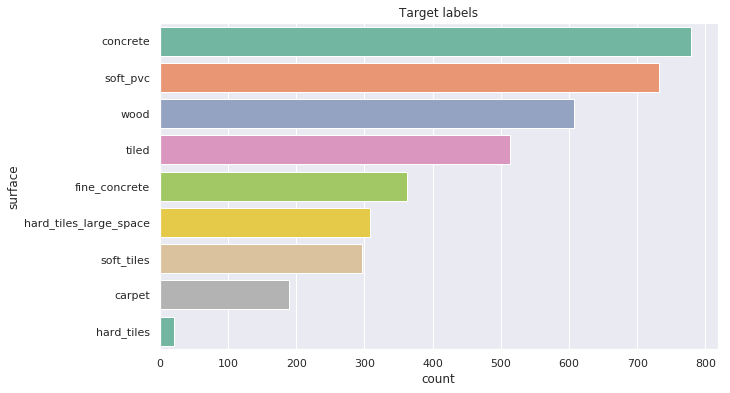

In [37]:
plt.figure(figsize=(10,6))
plt.title("Target labels")
sns.countplot(y='surface', data = Y_train_df, order = Y_train_df['surface'].value_counts().index,  palette="Set2")
plt.show()

The data is unbalanced! 

# Feature extraction

Let's extract 10 features from time series

We will use these papers  [link 1](https://ieeexplore.ieee.org/document/8181558) [link 2](https://www.sciencedirect.com/science/article/pii/S2405896318323127). We will use the top 10 features to vibration signal. 

In [38]:
from scipy.stats import kurtosis
from scipy.stats import skew

def _kurtosis(x):
    return kurtosis(x)

def CPT5(x):
    den = len(x)*np.exp(np.std(x))
    return sum(np.exp(x))/den

def skewness(x):
    return skew(x)

def SSC(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x,x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    # xn+1 
    xn_i1 = x[0:len(x)-2]  # xn-1
    ans = np.heaviside((xn-xn_i1)*(xn-xn_i2),0)
    return sum(ans[1:]) 

def wave_length(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x,x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    # xn+1 
    return sum(abs(xn_i2-xn))
    
def norm_entropy(x):
    tresh = 3
    return sum(np.power(abs(x),tresh))

def SRAV(x):    
    SRA = sum(np.sqrt(abs(x)))
    return np.power(SRA/len(x),2)

def mean_abs(x):
    return sum(abs(x))/len(x)

def zero_crossing(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x,x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    # xn+1
    return sum(np.heaviside(-xn*xn_i2,0))


In [39]:
def feature_extraction(raw_frame):
    frame = pd.DataFrame()
    raw_frame['angular_velocity'] = raw_frame['angular_velocity_X'] + raw_frame['angular_velocity_Y'] + raw_frame['angular_velocity_Z']
    raw_frame['linear_acceleration'] = raw_frame['linear_acceleration_X'] + raw_frame['linear_acceleration_Y'] + raw_frame['linear_acceleration_Z']
    raw_frame['velocity_to_acceleration'] = raw_frame['angular_velocity'] / raw_frame['linear_acceleration']
    
    for col in raw_frame.columns[3:]:
        frame[col + '_mean'] = raw_frame.groupby(['series_id'])[col].mean()        
        frame[col + '_CPT5'] = raw_frame.groupby(['series_id'])[col].apply(CPT5) 
        frame[col + '_SSC'] = raw_frame.groupby(['series_id'])[col].apply(SSC) 
        frame[col + '_skewness'] = raw_frame.groupby(['series_id'])[col].apply(skewness)
        frame[col + '_wave_lenght'] = raw_frame.groupby(['series_id'])[col].apply(wave_length)
        frame[col + '_norm_entropy'] = raw_frame.groupby(['series_id'])[col].apply(norm_entropy)
        frame[col + '_SRAV'] = raw_frame.groupby(['series_id'])[col].apply(SRAV)
        frame[col + '_kurtosis'] = raw_frame.groupby(['series_id'])[col].apply(_kurtosis) 
        frame[col + '_mean_abs'] = raw_frame.groupby(['series_id'])[col].apply(mean_abs) 
        frame[col + '_zero_crossing'] = raw_frame.groupby(['series_id'])[col].apply(zero_crossing) 
    return frame

In [40]:
train_df = feature_extraction(X_train_df)
test_df = feature_extraction(X_test_df)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


In [41]:
train_df.head()

,orientation_X_mean,orientation_X_CPT5,orientation_X_SSC,orientation_X_skewness,orientation_X_wave_lenght,orientation_X_norm_entropy,orientation_X_SRAV,orientation_X_kurtosis,orientation_X_mean_abs,orientation_X_zero_crossing,orientation_Y_mean,orientation_Y_CPT5,orientation_Y_SSC,orientation_Y_skewness,orientation_Y_wave_lenght,orientation_Y_norm_entropy,orientation_Y_SRAV,orientation_Y_kurtosis,orientation_Y_mean_abs,orientation_Y_zero_crossing,orientation_Z_mean,orientation_Z_CPT5,orientation_Z_SSC,orientation_Z_skewness,orientation_Z_wave_lenght,orientation_Z_norm_entropy,orientation_Z_SRAV,orientation_Z_kurtosis,orientation_Z_mean_abs,orientation_Z_zero_crossing,orientation_W_mean,orientation_W_CPT5,orientation_W_SSC,orientation_W_skewness,orientation_W_wave_lenght,orientation_W_norm_entropy,orientation_W_SRAV,orientation_W_kurtosis,orientation_W_mean_abs,orientation_W_zero_crossing,...,linear_acceleration_Z_mean,linear_acceleration_Z_CPT5,linear_acceleration_Z_SSC,linear_acceleration_Z_skewness,linear_acceleration_Z_wave_lenght,linear_acceleration_Z_norm_entropy,linear_acceleration_Z_SRAV,linear_acceleration_Z_kurtosis,linear_acceleration_Z_mean_abs,linear_acceleration_Z_zero_crossing,angular_velocity_mean,angular_velocity_CPT5,angular_velocity_SSC,angular_velocity_skewness,angular_velocity_wave_lenght,angular_velocity_norm_entropy,angular_velocity_SRAV,angular_velocity_kurtosis,angular_velocity_mean_abs,angular_velocity_zero_crossing,linear_acceleration_mean,linear_acceleration_CPT5,linear_acceleration_SSC,linear_acceleration_skewness,linear_acceleration_wave_lenght,linear_acceleration_norm_entropy,linear_acceleration_SRAV,linear_acceleration_kurtosis,linear_acceleration_mean_abs,linear_acceleration_zero_crossing,velocity_to_acceleration_mean,velocity_to_acceleration_CPT5,velocity_to_acceleration_SSC,velocity_to_acceleration_skewness,velocity_to_acceleration_wave_lenght,velocity_to_acceleration_norm_entropy,velocity_to_acceleration_SRAV,velocity_to_acceleration_kurtosis,velocity_to_acceleration_mean_abs,velocity_to_acceleration_zero_crossing
series_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,0.468122,11.0,-0.651333,0.00292,55.893558,0.758666,-0.667740,0.758666,0.0,-0.634008,0.530213,18.0,0.596105,0.00360,32.620769,0.634008,-1.186559,0.634008,0.0,-0.105474,0.899511,24.0,0.191036,0.006720,0.150200,0.105474,-1.238695,0.105474,0.0,-0.106470,0.898654,31.0,0.436372,0.006220,0.154491,0.106469,-0.867803,0.106470,0.0,...,-9.320391,0.000056,50.0,0.066599,103.8700,107883.468226,9.287890,0.465063,9.320391,0.0,0.001745,0.950363,63.0,-0.595751,4.726393,0.038651,0.032247,1.510703,0.039875,36.0,-6.072777,0.001696,76.0,-0.267946,198.353092,42877.420398,5.811652,-0.471855,6.072777,0.0,-0.000748,0.986734,63.0,-2.219887,1.052930,0.001020,0.006071,19.726029,0.007851,36.0
1,-0.958606,0.383369,22.0,-0.392618,0.00330,112.753747,0.958606,-0.664664,0.958606,0.0,0.241867,1.272992,23.0,-0.417597,0.01048,1.811111,0.241867,-0.561910,0.241867,0.0,0.031650,1.031634,55.0,-0.511099,0.007380,0.004061,0.031648,-0.759851,0.031650,0.0,-0.146876,0.862953,40.0,-0.167556,0.013820,0.405578,0.146875,-0.779464,0.146876,0.0,...,-9.388899,0.000119,54.0,-0.125356,207.2168,122214.057104,9.262838,1.257865,9.388899,0.0,0.003054,0.900920,51.0,-0.110191,9.334179,0.309574,0.075986,0.157144,0.089984,32.0,-6.498839,0.063208,66.0,-0.184836,372.910324,66502.446746,6.131039,1.312642,6.599944,4.0,-0.000794,0.909120,58.0,4.347738,4.943778,1.004801,0.016668,62.169640,0.029200,32.0
2,-0.512057,0.598440,10.0,0.150184,0.01008,17.186012,0.512056,-1.058422,0.512057,0.0,-0.846171,0.428719,11.0,-0.159884,0.00598,77.550642,0.846171,-1.086832,0.846171,0.0,-0.129371,0.878175,27.0,-0.034001,0.008440,0.277166,0.129370,-1.306001,0.129371,0.0,-0.071082,0.931128,44.0,0.505030,0.006544,0.045973,0.071082,-0.726609,0.071082,0.0,...,-9.395783,0.000054,61.0,0.084867,115.9818,110810.284432,9.360735,0.382548,9.395783,0.0,0.021403,0.954548,62.0,0.3425

In [42]:
train_df.shape, test_df.shape

((3810, 130), (3816, 130))

Fix -inf, +inf and NaN

In [43]:

train_df.fillna(0, inplace = True)
train_df.replace(-np.inf, 0, inplace = True)
train_df.replace(np.inf, 0, inplace = True)
test_df.fillna(0, inplace = True)
test_df.replace(-np.inf, 0, inplace = True)
test_df.replace(np.inf, 0, inplace = True)

Standarization

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(train_df))
X_test_scaled = pd.DataFrame(scaler.transform(test_df))

/opt/conda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1508: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


# LightGBM classifier 

In [22]:
le = LabelEncoder()
target = le.fit_transform(Y_train_df['surface'])

In [45]:
params = {
    'num_leaves': 54,
    'min_data_in_leaf': 40,
    'objective': 'multiclass',
    'max_depth': 8,
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "bagging_freq": 5,
    "bagging_fraction": 0.8126672064208567,
    "bagging_seed": 11,
    "verbosity": -1,
    'reg_alpha': 0.1302650970728192,
    'reg_lambda': 0.3603427518866501,
    "num_class": 9,
    'nthread': -1
}

def multiclass_accuracy(preds, train_data):
    labels = train_data.get_label()
    pred_class = np.argmax(preds.reshape(9, -1).T, axis=1)
    return 'multi_accuracy', np.mean(labels == pred_class), True

t0 = time.time()
train_set = lgb.Dataset(X_train_scaled, label=target)
eval_hist = lgb.cv(params, train_set, nfold=10, num_boost_round=9999,
                   early_stopping_rounds=100, seed=19, feval=multiclass_accuracy)
num_rounds = len(eval_hist['multi_logloss-mean'])

# retrain the model and make predictions for test set
clf = lgb.train(params, train_set, num_boost_round=num_rounds)
predictions = clf.predict(X_test_scaled, num_iteration=None)
print("Timer: {:.1f}s".format(time.time() - t0))

Timer: 532.9s


The following plots show the mean logloss and accuracy at each iteration (blue line). The red lines are the standard deviation between folds.

Validation logloss: 0.3665, accuracy: 0.8790


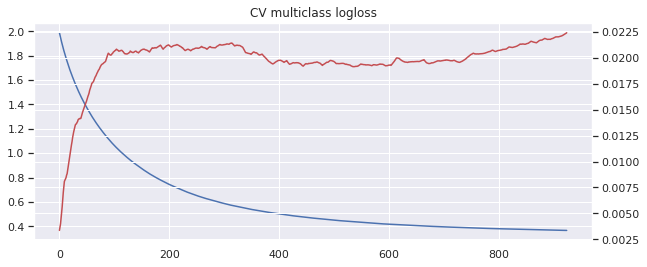

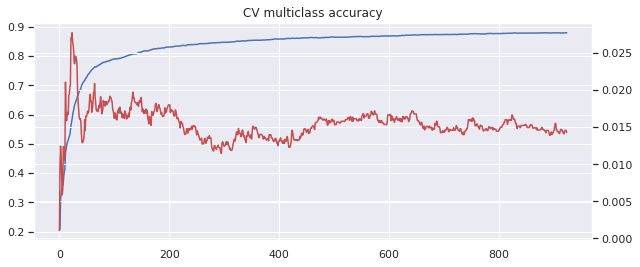

In [46]:
v1, v2 = eval_hist['multi_logloss-mean'][-1], eval_hist['multi_accuracy-mean'][-1]
print("Validation logloss: {:.4f}, accuracy: {:.4f}".format(v1, v2))
plt.figure(figsize=(10, 4))
plt.title("CV multiclass logloss")
num_rounds = len(eval_hist['multi_logloss-mean'])
ax = sns.lineplot(x=range(num_rounds), y=eval_hist['multi_logloss-mean'])
ax2 = ax.twinx()
p = sns.lineplot(x=range(num_rounds), y=eval_hist['multi_logloss-stdv'], ax=ax2, color='r')

plt.figure(figsize=(10, 4))
plt.title("CV multiclass accuracy")
num_rounds = len(eval_hist['multi_accuracy-mean'])
ax = sns.lineplot(x=range(num_rounds), y=eval_hist['multi_accuracy-mean'])
ax2 = ax.twinx()
p = sns.lineplot(x=range(num_rounds), y=eval_hist['multi_accuracy-stdv'], ax=ax2, color='r') 

### LGBM submission

In [49]:
sub['surface'] = le.inverse_transform(predictions.argmax(axis=1))
sub.to_csv('submission_lgbm.csv', index=False)

# Random forest

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_train_scaled, target, test_size=0.2, random_state=23, stratify=target)

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Number of optimal trees
# -You can test other values
optimal_k = 120 
rf_acc = []

# Optimal trees
rf_clf = RandomForestClassifier(n_estimators=optimal_k, random_state=0)        
# Train data split
rf_clf.fit(X_train, Y_train)

# Accuracy test data split
Y_pred = rf_clf.predict(X_test)
acc = accuracy_score(Y_pred,Y_test)

print('Acc_Test:')
print(float("%0.3f" % (100*acc)))

Acc_Test:
85.039


In [59]:
#With original data
rf_clf.fit(X_train_scaled, target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

# RF submission

In [60]:
Y_test_sub = rf_clf.predict(X_test_scaled)
sub['surface'] = le.inverse_transform(Y_test_sub)
sub.to_csv('submission_rf.csv', index=False)